# Online Retail analysis using PySpark

## 1. Introduction
Hello, welcome to my analysis. This is my practice as part of a self-study course to learn PySpark. PySpark is a powerful library for working with big data. The purpose of the analysis is to identify patterns in online trading activities by answering a number of questions:

       1. In which countries did the company earn high revenues?
       2. At what time of year did the company receive high income?
       3. At what time of day is purchasing power higher than at any other time?

## 2. About dataset
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Link of dataset: https://archive.ics.uci.edu/dataset/352/online+retail

## 3. Dataset Characteristics
Dataset has 541909 records with 8 features:
   * InvoiceNo: a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
   * StockCode: a 5-digit integral number uniquely assigned to each distinct product
   * Description: product name
   * Quantity: the quantities of each product (item) per transaction
   * InvoiceDate: the day and time when each transaction was generated
   * UnitPrice: product price per unit
   * CustomerID: a 5-digit integral number uniquely assigned to each customer
   * Country: the name of the country where each customer resides

##  4. Import essential library

In [1]:
# Library for config pyspark
import findspark
findspark.init()
import pyspark

# Library for SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName('online-retail').setMaster('local')
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

# Library for SQL conducting
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, TimestampType, DecimalType
from pyspark.sql.functions import to_timestamp, col, format_number, date_format, month, year, quarter, hour

# Library for processing data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

## 5. Open file Retail

In [2]:
df = spark.read.csv('OnlineRetail.csv', sep = ';', header = True)

In [3]:
print(df.count())
df.printSchema()

541909
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [4]:
df.show(10)

+---------+---------+--------------------+--------+-------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|  InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01-12-10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01-12-10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01-12-10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01-12-10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01-12-10 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|01-12-10 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|01-12-10 8:26|     4.25|     17

## 6. Preprocess data

#### Our data has 541909 transactions with 8 features. Let's check number of missing values in each column

In [5]:
for column in df.columns:
    criteria = f'{column} is null'
    missing_values = df.filter(criteria).count()
    print(f'Column {column} has {missing_values} missing values')

Column InvoiceNo has 0 missing values
Column StockCode has 0 missing values
Column Description has 1454 missing values
Column Quantity has 0 missing values
Column InvoiceDate has 0 missing values
Column UnitPrice has 0 missing values
Column CustomerID has 135080 missing values
Column Country has 0 missing values


Most of missing values are in column "CustomerID", deleting this column causes insufficient data, so we keep it.
#### Next, we will change the type of columns "Quantity", "UnitPrice" and "InvoiceDate"

In [6]:
# change the type of columns
df = df.withColumn('Quantity', df['Quantity'].cast(IntegerType()))
df = df.withColumn('UnitPrice', df['UnitPrice'].cast(DecimalType(10,2)))
df = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate",'dd-MM-yy H:mm'))

In [7]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: decimal(10,2) (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [8]:
df.describe(['Quantity', 'UnitPrice']).show()

+-------+------------------+-----------------+
|summary|          Quantity|        UnitPrice|
+-------+------------------+-----------------+
|  count|            541909|           541909|
|   mean|  9.55224954743324|         4.611114|
| stddev|218.08115785023355|96.75985306153039|
|    min|            -80995|        -11062.06|
|    max|             80995|         38970.00|
+-------+------------------+-----------------+



#### The min values of two columns are negative, maybe something's wrong here? Let's analyze more detail.

In [9]:
df.filter("Quantity < 0").show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  C536379|        D|            Discount|      -1|2010-12-01 09:41:00|    27.50|     14527|United Kingdom|
|  C536383|   35004C|SET OF 3 COLOURED...|      -1|2010-12-01 09:49:00|     4.65|     15311|United Kingdom|
|  C536391|    22556|PLASTERS IN TIN C...|     -12|2010-12-01 10:24:00|     1.65|     17548|United Kingdom|
|  C536391|    21984|PACK OF 12 PINK P...|     -24|2010-12-01 10:24:00|     0.29|     17548|United Kingdom|
|  C536391|    21983|PACK OF 12 BLUE P...|     -24|2010-12-01 10:24:00|     0.29|     17548|United Kingdom|
|  C536391|    21980|PACK OF 12 RED RE...|     -24|2010-12-01 10:24:00|     0.29|     17548|United Kingdom|
|  C536391|    21484|CHICK G

Ohh, I think I found out the rule! If the value of column "InvoiceNo" starts by "C", the quantity value is negative. That is because when the cancellation, the good will be gotten back, so we have negative values here. Let's check this rule!  

In [10]:
df.filter( (df["Quantity"] >= 0) & (df["InvoiceNo"].rlike("^[C]\d+")) ).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [11]:
C_row = df.filter(col("InvoiceNo").rlike("^[C]\d+"))
C_row.count()  #number of rows which start by "C" in column "InvoiceNo"

9288

In [12]:
quan_smaller0 = df.filter("Quantity < 0")
quan_smaller0.count() #number of rows which quantity < 0

10624

Yes, the rule is right, because all the values of column "InvoiceNo", which start by "C", have negative vaues in column "Quantity". However, you can see the value of C_row is smaller than quan_smaller (9288 < 10624), is there any rule here, that we don't know?

In [13]:
# rows which quantity < 0 and start by number (not "C") in column "InvoiceNo"
quan_smaller0_notC = df.filter( (df["Quantity"] < 0) & (df["InvoiceNo"].rlike("^\d+")) )
print(quan_smaller0_notC.count())
quan_smaller0_notC.show()

1336
+---------+---------+-----------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+-----------+--------+-------------------+---------+----------+--------------+
|   536589|    21777|       null|     -10|2010-12-01 16:50:00|     0.00|      null|United Kingdom|
|   536764|   84952C|       null|     -38|2010-12-02 14:42:00|     0.00|      null|United Kingdom|
|   536996|    22712|       null|     -20|2010-12-03 15:30:00|     0.00|      null|United Kingdom|
|   536997|    22028|       null|     -20|2010-12-03 15:30:00|     0.00|      null|United Kingdom|
|   536998|    85067|       null|      -6|2010-12-03 15:30:00|     0.00|      null|United Kingdom|
|   537000|    21414|       null|     -22|2010-12-03 15:32:00|     0.00|      null|United Kingdom|
|   537001|    21653|       null|      -6|2010-12-03 15:33:00|     0.00|      null|United Kingdom|
|   5

In [14]:
quan_smaller0_notC.filter(quan_smaller0_notC["UnitPrice"] == 0).count()

1336

In [15]:
quan_smaller0_notC.filter(col("CustomerID").isNull()).count()

1336

#### I decide to delete 1336 rows by following reasons:
    
    1. It not follows the rule above (InvoiceNo starts by "C" -> Quantity (-)).
    2. All values in column CustomerID is Null.
    3. All values in column UnitPrice equal 0.

In [16]:
# Remove 1336 rows
df1 = df.subtract(quan_smaller0_notC)

In [17]:
# Price can't be negative => Remove them from data
price_smaller_equal0 = df1.filter("UnitPrice < 0")
df2 = df1.subtract(price_smaller_equal0)

In [18]:
df2.count()

535303

## 7. Create dataframe by using Query SQL

In [19]:
print(df2.select('StockCode').distinct().count())
df2.select('StockCode').distinct().collect()

3957


[Row(StockCode='21889'),
 Row(StockCode='22728'),
 Row(StockCode='22254'),
 Row(StockCode='21248'),
 Row(StockCode='22596'),
 Row(StockCode='23318'),
 Row(StockCode='21259'),
 Row(StockCode='90022'),
 Row(StockCode='21249'),
 Row(StockCode='21452'),
 Row(StockCode='21894'),
 Row(StockCode='20868'),
 Row(StockCode='22121'),
 Row(StockCode='90197B'),
 Row(StockCode='90210B'),
 Row(StockCode='21331'),
 Row(StockCode='85132b'),
 Row(StockCode='90143'),
 Row(StockCode='90026D'),
 Row(StockCode='84881'),
 Row(StockCode='90177A'),
 Row(StockCode='23459'),
 Row(StockCode='23843'),
 Row(StockCode='85115B'),
 Row(StockCode='21671'),
 Row(StockCode='23113'),
 Row(StockCode='84212'),
 Row(StockCode='23514'),
 Row(StockCode='21534'),
 Row(StockCode='21535'),
 Row(StockCode='22436'),
 Row(StockCode='22314'),
 Row(StockCode='22130'),
 Row(StockCode='21711'),
 Row(StockCode='23479'),
 Row(StockCode='84884a'),
 Row(StockCode='40046A'),
 Row(StockCode='17084J'),
 Row(StockCode='gift_0001_50'),
 Row(Stoc

In [20]:
print(df2.select('Country').distinct().count())
df2.select('Country').distinct().collect()

38


[Row(Country='Sweden'),
 Row(Country='Singapore'),
 Row(Country='Germany'),
 Row(Country='RSA'),
 Row(Country='France'),
 Row(Country='Greece'),
 Row(Country='European Community'),
 Row(Country='Belgium'),
 Row(Country='Finland'),
 Row(Country='Malta'),
 Row(Country='Unspecified'),
 Row(Country='Italy'),
 Row(Country='EIRE'),
 Row(Country='Lithuania'),
 Row(Country='Norway'),
 Row(Country='Spain'),
 Row(Country='Denmark'),
 Row(Country='Hong Kong'),
 Row(Country='Israel'),
 Row(Country='Iceland'),
 Row(Country='Channel Islands'),
 Row(Country='USA'),
 Row(Country='Cyprus'),
 Row(Country='Saudi Arabia'),
 Row(Country='Switzerland'),
 Row(Country='United Arab Emirates'),
 Row(Country='Canada'),
 Row(Country='Czech Republic'),
 Row(Country='Brazil'),
 Row(Country='Lebanon'),
 Row(Country='Japan'),
 Row(Country='Poland'),
 Row(Country='Portugal'),
 Row(Country='Australia'),
 Row(Country='Austria'),
 Row(Country='Bahrain'),
 Row(Country='United Kingdom'),
 Row(Country='Netherlands')]

There are 3937 unique values in column "StockCode" and 38 countries in this dataset.

#### Column "TotalRevenue" are created.

In [21]:
df2 = df2.withColumn('Revenue', col('Quantity')*col('UnitPrice')) # Create TotalRevenue column

In [22]:
df2.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|Revenue|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------+
|   544484|    85152|HAND OVER THE CHO...|      12|2011-02-21 11:10:00|     2.10|     15321|United Kingdom|  25.20|
|   544911|    22798|ANTIQUE GLASS DRE...|       8|2011-02-24 15:01:00|     2.95|     16838|United Kingdom|  23.60|
|   554511|    22669|   RED BABY BUNTING |       1|2011-05-24 15:52:00|     5.79|      null|United Kingdom|   5.79|
|   559817|   84596G|SMALL CHOCOLATES ...|       1|2011-07-12 16:20:00|     0.83|      null|United Kingdom|   0.83|
|  C560540|    23242|TREASURE TIN BUFF...|      -1|2011-07-19 12:26:00|     2.08|     12415|     Australia|  -2.08|
+---------+---------+--------------------+--------+-------------------+-

#### Query TotalRevenue by Country

In [23]:
df2.createOrReplaceTempView('revenueByCountry')
query = """
SELECT  Country as country, 
        SUM(Revenue) as totalRevenue,
        SUM(Revenue) / SUM(SUM(Revenue)) OVER() as percent_whole_revenue 
    FROM revenueByCountry
    GROUP BY Country
    ORDER BY 2 DESC
    LIMIT 10
"""
print(query)
country = spark.sql(query)
country.show()


SELECT  Country as country, 
        SUM(Revenue) as totalRevenue,
        SUM(Revenue) / SUM(SUM(Revenue)) OVER() as percent_whole_revenue 
    FROM revenueByCountry
    GROUP BY Country
    ORDER BY 2 DESC
    LIMIT 10

+--------------+------------+---------------------+
|       country|totalRevenue|percent_whole_revenue|
+--------------+------------+---------------------+
|United Kingdom|  8189252.30|            0.8400843|
|   Netherlands|   284661.54|            0.0292017|
|          EIRE|   262993.38|            0.0269789|
|       Germany|   221509.47|            0.0227233|
|        France|   197317.11|            0.0202415|
|     Australia|   137009.77|            0.0140550|
|   Switzerland|    56363.05|            0.0057819|
|         Spain|    54756.03|            0.0056171|
|       Belgium|    40910.96|            0.0041968|
|        Sweden|    36585.41|            0.0037531|
+--------------+------------+---------------------+



#### Query TotalRevenue by Month

In [24]:
df2 = df2.withColumn('month_invoice', month(df2['InvoiceDate']))
df2 = df2.withColumn('quarter_invoice', quarter(df2['InvoiceDate']))
df2 = df2.withColumn('hour_invoice', hour(df2['InvoiceDate']))

In [25]:
df2.show(1)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------+-------------+---------------+------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|Revenue|month_invoice|quarter_invoice|hour_invoice|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------+-------------+---------------+------------+
|   544484|    85152|HAND OVER THE CHO...|      12|2011-02-21 11:10:00|     2.10|     15321|United Kingdom|  25.20|            2|              1|          11|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------+-------------+---------------+------------+
only showing top 1 row



In [26]:
df2.createOrReplaceTempView('revenueByMonth')
query = """
SELECT  month_invoice, 
        SUM(revenue) as totalRevenue,
        SUM(revenue) / SUM(SUM(revenue)) OVER() as percent_whole
    FROM revenueByMonth
    GROUP BY month_invoice
    ORDER BY 1
"""
by_month = spark.sql(query)
by_month.show()

+-------------+------------+-------------+
|month_invoice|totalRevenue|percent_whole|
+-------------+------------+-------------+
|            1|   558448.56|    0.0572878|
|            2|   497026.41|    0.0509868|
|            3|   682013.98|    0.0699636|
|            4|   492367.84|    0.0505089|
|            5|   722094.10|    0.0740751|
|            6|   689977.23|    0.0707805|
|            7|   680156.99|    0.0697731|
|            8|   703510.58|    0.0721688|
|            9|  1017596.68|    0.1043889|
|           10|  1069368.23|    0.1096998|
|           11|  1456145.80|    0.1493769|
|           12|  1179424.67|    0.1209898|
+-------------+------------+-------------+



#### Query TotalRevenue by Quarter

In [27]:
df2.createOrReplaceTempView('revenueByQuarter')
query = """
SELECT  quarter_invoice, 
        SUM(revenue) as totalRevenue,
        SUM(revenue) / SUM(SUM(revenue)) OVER() as percent_whole
    FROM revenueByQuarter
    GROUP BY quarter_invoice
    ORDER BY 1
"""
by_quarter = spark.sql(query)
by_quarter.show()

+---------------+------------+-------------+
|quarter_invoice|totalRevenue|percent_whole|
+---------------+------------+-------------+
|              1|  1737488.95|    0.1782382|
|              2|  1904439.17|    0.1953645|
|              3|  2401264.25|    0.2463307|
|              4|  3704938.70|    0.3800666|
+---------------+------------+-------------+



#### Query TotalRevenue by Hour

In [28]:
df2.createOrReplaceTempView('revenueByHour')
query = """
SELECT  hour_invoice, 
        SUM(revenue) as totalRevenue,
        SUM(revenue) / SUM(SUM(revenue)) OVER() as percent_whole
    FROM revenueByHour
    GROUP BY hour_invoice
    ORDER BY 1
"""
by_hour = spark.sql(query)
by_hour.show()

+------------+------------+-------------+
|hour_invoice|totalRevenue|percent_whole|
+------------+------------+-------------+
|           6|     -497.35|   -0.0000510|
|           7|    31009.32|    0.0031811|
|           8|   281723.02|    0.0289002|
|           9|   766524.17|    0.0786329|
|          10|  1327329.89|    0.1361625|
|          11|  1146457.49|    0.1176079|
|          12|  1357595.12|    0.1392672|
|          13|  1172985.87|    0.1203293|
|          14|  1113532.86|    0.1142304|
|          15|  1186819.41|    0.1217484|
|          16|   727666.67|    0.0746468|
|          17|   434834.54|    0.0446070|
|          18|   140365.04|    0.0143992|
|          19|    45864.93|    0.0047050|
|          20|    15920.09|    0.0016331|
+------------+------------+-------------+



## 8. Visualization results

In [29]:
# convert dataframe.pyspark to dataframe.pandas for convenient visualization
country = country.toPandas()
by_month = by_month.toPandas()
by_hour =  by_hour.toPandas()
by_quarter = by_quarter.toPandas()

In [30]:
by_quarter.quarter_invoice = by_quarter.quarter_invoice.astype('string')
by_hour.hour_invoice = by_hour.hour_invoice.astype('string')

In [31]:
# get all months name using number
month_name = []
for i in range(1, 13):
    name = calendar.month_abbr[i]
    month_name.append(name)
    
by_month['month_name'] = month_name
by_month

,month_invoice,totalRevenue,percent_whole,month_name
0,1,558448.56,0.0572878,Jan
1,2,497026.41,0.0509868,Feb
2,3,682013.98,0.0699636,Mar
3,4,492367.84,0.0505089,Apr
4,5,722094.10,0.0740751,May
5,6,689977.23,0.0707805,Jun
6,7,680156.99,0.0697731,Jul
7,8,703510.58,0.0721688,Aug
8,9,1017596.68,0.1043889,Sep
9,10,1069368.23,0.1096998,Oct


In [32]:
# highlight the highest revenue

## by country
country_max = country.copy()
country_max.iloc[1:10, 1:3] = 0

## by month
month_max = by_month.copy()
month_max.iloc[:10, 1:3] = 0
month_max.iloc[11, 1:3] = 0

## by quarter
quarter_max = by_quarter.copy()
quarter_max.iloc[:3, 1:3] = 0

## by hour
hour_max = by_hour.copy()
hour_max = by_hour.copy()
hour_max.iloc[:4, 1:3] = 0
hour_max.iloc[ 5, 1:3] = 0
hour_max.iloc[7:, 1:3] = 0

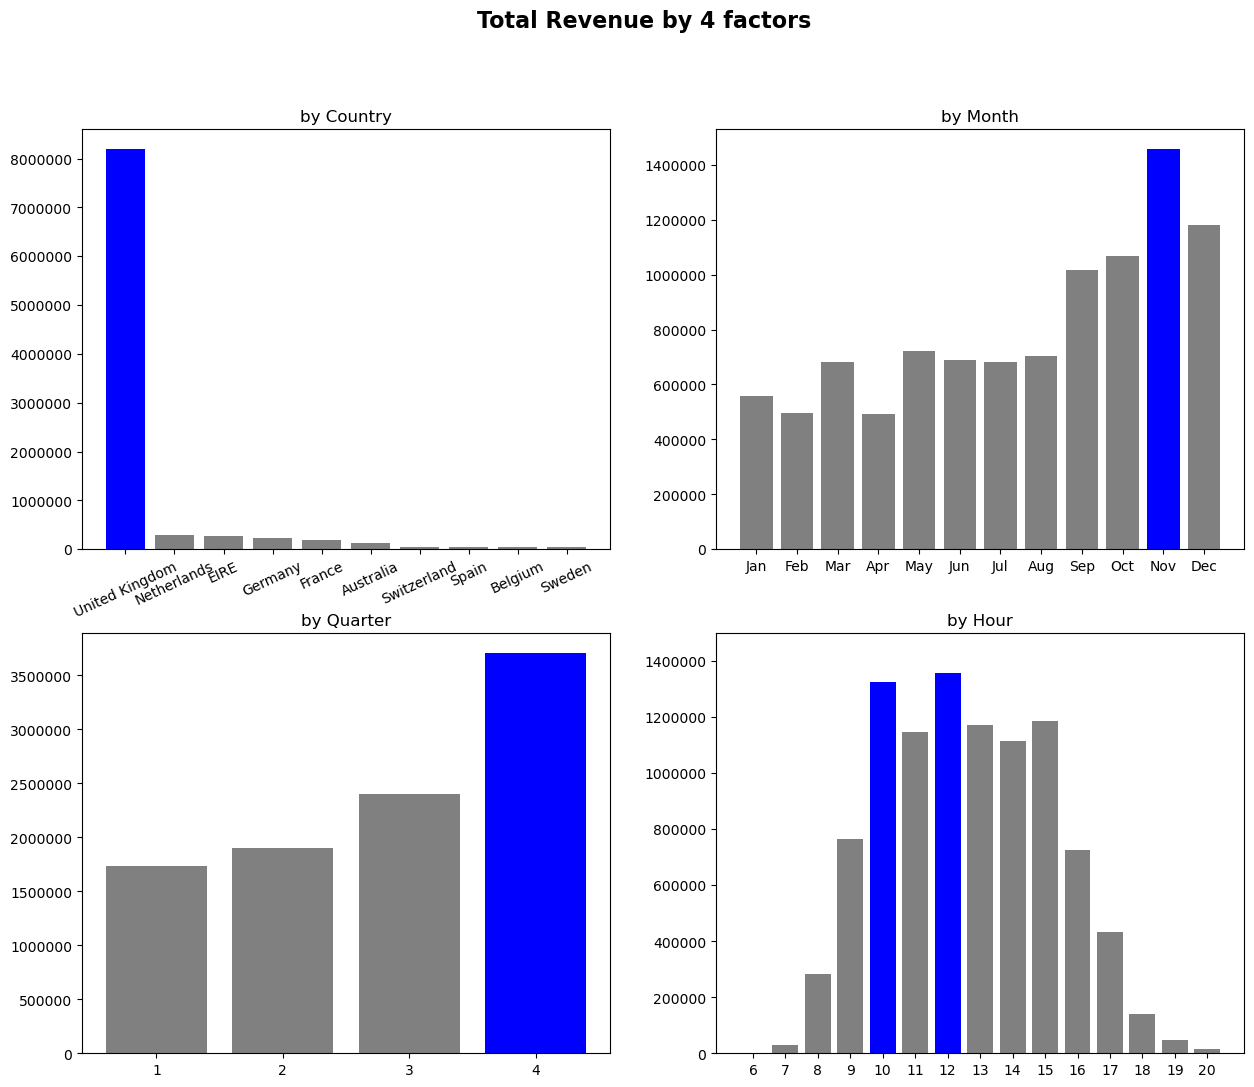

In [33]:
fig, ( (ax0, ax1), (ax2, ax3) ) = plt.subplots(nrows= 2, ncols = 2, figsize = (15,12))
fig.suptitle('Total Revenue by 4 factors', 
             fontsize = 16, fontweight = 'bold')

# ax0
ax0.bar(x = country['country'],height = country['totalRevenue'], color = 'gray' )
ax0.bar(x = country_max['country'],height = country_max['totalRevenue'], color = 'blue' )
ax0.set(title = 'by Country')
ax0.tick_params(axis='x', labelrotation=25)
ax0.ticklabel_format(style='plain', axis='y')  #change from scientific notation to plain number

# ax1
ax1.bar(x = by_month['month_name'],height = by_month['totalRevenue'], color = 'gray'  )
ax1.bar(x = month_max['month_name'],height = month_max['totalRevenue'], color = 'blue'  )
ax1.set(title = 'by Month')
ax1.ticklabel_format(style='plain', axis='y')  #change from scientific notation to plain number

# ax2
ax2.bar(x = by_quarter['quarter_invoice'],height = by_quarter['totalRevenue'], color = 'gray'  )
ax2.bar(x = quarter_max['quarter_invoice'],height = quarter_max['totalRevenue'], color = 'blue'  )
ax2.set(title = 'by Quarter')
ax2.ticklabel_format(style='plain', axis='y')  #change from scientific notation to plain number

# ax3
ax3.bar(x = by_hour['hour_invoice'],height = by_hour['totalRevenue'], color = 'gray'  )
ax3.bar(x = hour_max['hour_invoice'],height = hour_max['totalRevenue'], color = 'blue'  )
ax3.set(title = 'by Hour')
ax3.set_ylim(0,1500000)
ax3.ticklabel_format(style='plain', axis='y')  #change from scientific notation to plain number

plt.show()

## 9. Conclusion
Thanks to visualization, everything is readable. We can conclude that:
- Since this platform operates mainly in the UK, the total revenue here was much higher than in any other country (it reached 84% of the whole revenue of the company).
- At the same time, the highest total income was observed in the 4th quarter, which amounted to 38% of the company’s total revenue and was almost twice as high as the first quarter. Purchasing power especially increased in November, when buyers were preparing gifts for important holidays of the year: Christmas and New Year.
- The last graph shows the total amount of money received by the company during the day. What's interesting here is that shoppers spent lots of money on products at 10 and 12 a.m. rather than in the evening, when people have time to relax after a hard-working day.

### I'm glad because you read my analysis to the end. Hope you enjoy it! 🤗🤗